In [22]:
import pandas as pd
import os
import random
import xml.etree.ElementTree as ET
from pathlib import Path
import numpy as np
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import resize
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [23]:
dataset_dir = '/Users/minhkha/Desktop/CS231/Đồ án/data'  # Thay bằng path đến folder tổng
images_dir = os.path.join(dataset_dir,'/Users/minhkha/Desktop/CS231/Đồ án/data/images') # thay bằng path đến images
xmls_dir = os.path.join(dataset_dir,'/Users/minhkha/Desktop/CS231/Đồ án/data/annotations/xmls') # thay bằng path đến xmls

In [24]:
def parse_oxford_pet_dataset_with_bbox(images_dir, xmls_dir):
    data = []

    xml_files = [f for f in os.listdir(xmls_dir) if f.endswith('.xml')]

    for xml_file in xml_files:
        image_id = xml_file[:-4]  # remove '.xml'
        image_path = os.path.join(images_dir, image_id + '.jpg')
        xml_path = os.path.join(xmls_dir, xml_file)

        # Xác định cat/dog dựa vào ký tự đầu tiên
        label = 'cat' if image_id[0].isupper() else 'dog'

        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()
            obj = root.find('object')
            bndbox = obj.find('bndbox')
            bbox = {
                'xmin': int(bndbox.find('xmin').text),
                'ymin': int(bndbox.find('ymin').text),
                'xmax': int(bndbox.find('xmax').text),
                'ymax': int(bndbox.find('ymax').text)
            }
        except Exception as e:
            print(f"Error reading {xml_path}: {e}")
            continue

        data.append({
            'image_path': image_path,
            'label': label,
            'bbox': bbox
        })

    return data

In [25]:
def make_square(xmin, xmax, ymin, ymax):
    """Chuyển bounding box thành hình vuông"""
    xcenter = (xmax + xmin) // 2
    ycenter = (ymax + ymin) // 2
    halfdim = min(xmax - xmin, ymax - ymin) // 2
    xmin, xmax = xcenter - halfdim, xcenter + halfdim
    ymin, ymax = ycenter - halfdim, ycenter + halfdim
    return xmin, xmax, ymin, ymax

In [26]:
data = parse_oxford_pet_dataset_with_bbox(images_dir, xmls_dir)

# test việc đọc có ổn không
for item in data[:3]:
    print(item)

{'image_path': '/Users/minhkha/Desktop/CS231/Đồ án/data/images/British_Shorthair_10.jpg', 'label': 'cat', 'bbox': {'xmin': 83, 'ymin': 29, 'xmax': 197, 'ymax': 142}}
{'image_path': '/Users/minhkha/Desktop/CS231/Đồ án/data/images/german_shorthaired_119.jpg', 'label': 'dog', 'bbox': {'xmin': 128, 'ymin': 22, 'xmax': 240, 'ymax': 222}}
{'image_path': '/Users/minhkha/Desktop/CS231/Đồ án/data/images/english_setter_158.jpg', 'label': 'dog', 'bbox': {'xmin': 97, 'ymin': 35, 'xmax': 304, 'ymax': 199}}


In [27]:
# Oversampling cho class mèo bằng với chó
df = pd.DataFrame(data)
df['label'] = df['label'].map({'cat': 0, 'dog': 1})
df = df.dropna(subset=['bbox'])

df_cats = df[df['label'] == 0]
df_dogs = df[df['label'] == 1]

print(f"Số mẫu mèo (cat) ban đầu: {len(df_cats)}")
print(f"Số mẫu chó (dog) ban đầu: {len(df_dogs)}")

# Oversampling: tăng số lượng mẫu của lớp "mèo" (cat) để bằng với lớp "chó" (dog) nếu mèo ít hơn
if len(df_cats) < len(df_dogs):
    # Oversampling lớp "mèo" bằng cách sao chép ngẫu nhiên các mẫu
    oversample_cats = df_cats.sample(len(df_dogs) - len(df_cats), replace=True, random_state=42)
    df_cats = pd.concat([df_cats, oversample_cats])


df_balanced = pd.concat([df_cats, df_dogs]).reset_index(drop=True)
print(f"Số mẫu mèo (cat) sau oversampling: {len(df_cats)}")
print(f"Số mẫu chó (dog) sau oversampling: {len(df_dogs)}")

df_train, df_test = train_test_split(df_balanced, test_size=0.1, random_state=42)
print(f"Số mẫu train: {len(df_train)}")
print(f"Số mẫu test: {len(df_test)}")

Số mẫu mèo (cat) ban đầu: 1188
Số mẫu chó (dog) ban đầu: 2498
Số mẫu mèo (cat) sau oversampling: 2498
Số mẫu chó (dog) sau oversampling: 2498
Số mẫu train: 4496
Số mẫu test: 500


In [28]:
df_train

image_path  label  \
47    /Users/minhkha/Desktop/CS231/Đồ án/data/images...      0   
3077  /Users/minhkha/Desktop/CS231/Đồ án/data/images...      1   
4718  /Users/minhkha/Desktop/CS231/Đồ án/data/images...      1   
2405  /Users/minhkha/Desktop/CS231/Đồ án/data/images...      0   
4094  /Users/minhkha/Desktop/CS231/Đồ án/data/images...      1   
...                                                 ...    ...   
4426  /Users/minhkha/Desktop/CS231/Đồ án/data/images...      1   
466   /Users/minhkha/Desktop/CS231/Đồ án/data/images...      0   
3092  /Users/minhkha/Desktop/CS231/Đồ án/data/images...      1   
3772  /Users/minhkha/Desktop/CS231/Đồ án/data/images...      1   
860   /Users/minhkha/Desktop/CS231/Đồ án/data/images...      0   

                                                   bbox  
47    {'xmin': 183, 'ymin': 7, 'xmax': 320, 'ymax': ...  
3077  {'xmin': 93, 'ymin': 39, 'xmax': 251, 'ymax': ...  
4718  {'xmin': 158, 'ymin': 57, 'xmax': 337, 'ymax':...  
2405  {'xmin': 73, 'ymin': 37, 'xmax': 231, 'ymax': ...  
4094  {'xmin': 157, 'ymin': 114, 'xmax': 355, 'ymax'...  
...                                                 ...  
4426  {'xmin': 176, 'ymin': 62, 'xmax': 352, 'ymax':...  
466   {'xmin': 224, 'ymin': 3, 'xmax': 368, 'ymax': ...  
3092  {'xmin': 242, 'ymin': 11, 'xmax': 377, 'ymax':...  
3772  {'xmin': 122, 'ymin': 24, 'xmax': 379, 'ymax':...  
860   {'xmin': 84, 'ymin': 8, 'xmax': 271, 'ymax': 209}  

[4496 rows x 3 columns]

Hiển thị 5 ảnh đầu tiên từ df_balanced:


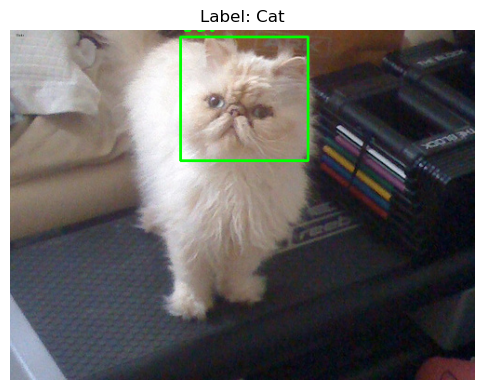

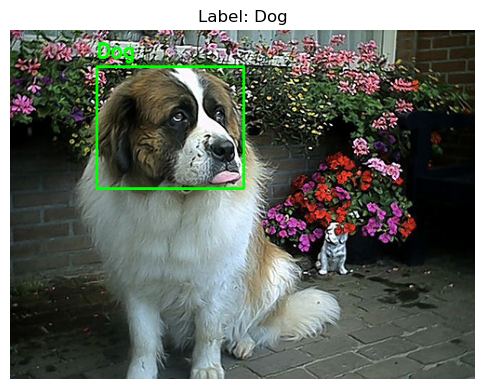

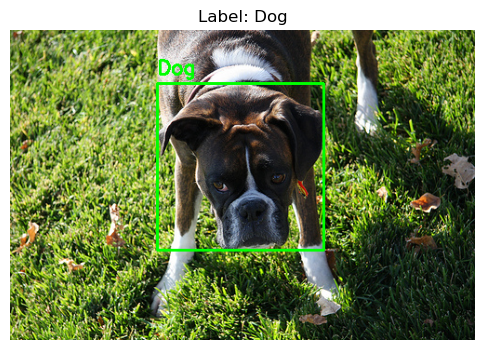

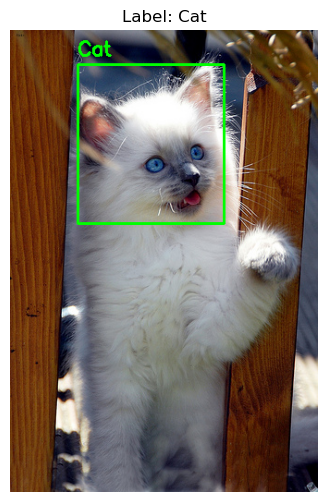

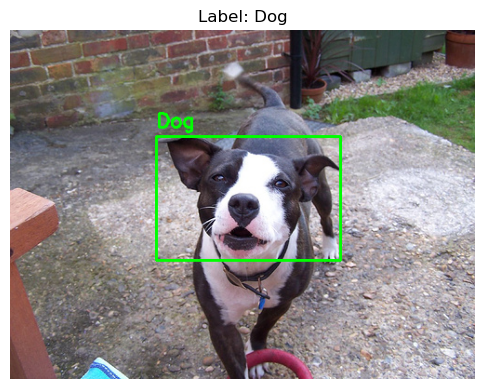

In [29]:
# Hiển thị 5 ảnh đầu tiên từ df_balanced cùng với nhãn và bounding box
def display_images_with_bbox(df, num_images=5):
    for idx, row in df.head(num_images).iterrows():
        # Đọc ảnh
        img = imread(row['image_path'])
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)
        img_cv = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        label = 'Cat' if row['label'] == 0 else 'Dog'
        bbox = row['bbox']
        
        if bbox:
            xmin, ymin, xmax, ymax = bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']
            cv2.rectangle(img_cv, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            cv2.putText(img_cv, label, (xmin, max(0, ymin-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        # Chuyển về RGB để hiển thị
        img_display = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
        
        # Hiển thị
        plt.figure(figsize=(6, 6))
        plt.imshow(img_display)
        plt.axis('off')
        plt.title(f"Label: {label}")
        plt.show()

# Gọi hàm để hiển thị
print("Hiển thị 5 ảnh đầu tiên từ df_balanced:")
display_images_with_bbox(df_train, num_images=5)

In [30]:
# Hàm trích xuất đặc trưng HOG
WINDOW_SIZE = (128, 128)  
# PIXELS = (8, 8)  # Kích thước pixel per cell
def extract_hog(img, size=WINDOW_SIZE):
    img = cv2.resize(img, size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Chuyển sang grayscale
    feature = hog(img, 
             orientations=9, 
             pixels_per_cell=(8, 8), 
             cells_per_block=(2, 2), 
             block_norm='L2-Hys',
             visualize=False)
    return feature

In [31]:
def extract_hog_from_df(df):
    features = []
    labels = []

    for _, index in df.iterrows():
        image = cv2.imread(index['image_path'])
        feature = extract_hog(image, (128, 64))
        features.append(feature)
        labels.append(index['label'])

    print(f"Số lượng đặc trưng đã trích xuất: {len(features)}")

    return np.array(features), np.array(labels)

In [32]:
X_train, y_train = extract_hog_from_df(df_train)
X_test, y_test = extract_hog_from_df(df_test)

Corrupt JPEG data: 245 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Số lượng đặc trưng đã trích xuất: 4496
Số lượng đặc trưng đã trích xuất: 500


In [33]:
cls_scacler = StandardScaler()
X_train_scaled = cls_scacler.fit_transform(X_train)
X_test_scaled = cls_scacler.transform(X_test)

In [34]:
cls_model = SVC(kernel='rbf', C=10, gamma='scale' ,random_state=42)
cls_model.fit(X_train_scaled, y_train)

SVC(C=10, random_state=42)

In [35]:
y_pred = cls_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       267
           1       0.83      0.89      0.86       233

    accuracy                           0.87       500
   macro avg       0.87      0.87      0.87       500
weighted avg       0.87      0.87      0.87       500



In [37]:
conf_matrix = confusion_matrix(y_test, y_pred)

conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=["Cat (0)", "Dog (1)"],  # Nhãn cho hàng
                              columns=["Predicted Cat (0)", "Predicted Dog (1)"])  # Nhãn cho cột

print(conf_matrix_df)

         Predicted Cat (0)  Predicted Dog (1)
Cat (0)                226                 41
Dog (1)                 26                207


In [38]:
print(f"Recall: {recall}")

Recall: 0.866


In [39]:
def classify_image_from_path(img_path, model, scaler):
    img = cv2.imread(img_path)
    feature = extract_hog(img, (128, 64))
    feature_scaled = scaler.transform([feature])
    prediction = model.predict(feature_scaled)
    confidence = model.decision_function(feature_scaled)
    return prediction[0], confidence

In [40]:
image_path = '/Users/minhkha/Downloads/image9-1631785551-12-width650height470.jpg'  # Thay bằng đường dẫn thực tế
predicted_label, confi = classify_image_from_path(image_path, cls_model, cls_scacler)
predicted_label_str = 'Cat' if predicted_label == 0 else 'Dog'
print(f"Dự đoán cho ảnh {image_path}: {predicted_label_str}")

Dự đoán cho ảnh /Users/minhkha/Downloads/image9-1631785551-12-width650height470.jpg: Dog


In [41]:
def classify_image(img, model, scaler):
    # img = cv2.resize(img, (128, 64))
    feature = extract_hog(img, (128, 64))
    feature_scaled = scaler.transform([feature])
    prediction = model.predict(feature_scaled)
    predicted_label = 'Cat' if prediction == 0 else 'Dog'
    return predicted_label

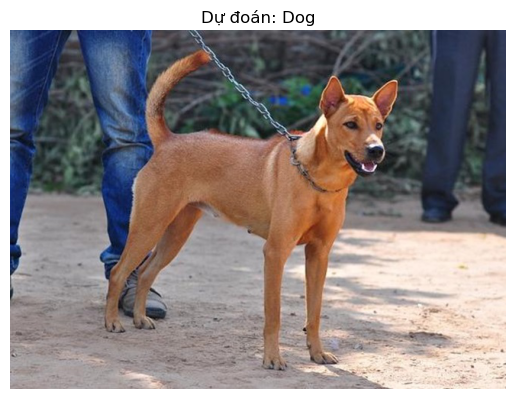

In [66]:
test_image_path = '/Users/minhkha/Downloads/image9-1631785551-12-width650height470.jpg'  
img = cv2.imread(test_image_path)
label = classify_image(img, cls_model, cls_scacler)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Dự đoán: {label}")
plt.axis('off')
plt.show()

In [67]:
positive = []
negative = []
positive_paths = []
negative_paths = []

# Thu thập positive samples (mặt chó và mèo)
for _, item in df_train.iterrows():
    img = cv2.imread(item['image_path'])
    if img is None:
        print(f"Không thể đọc ảnh: {item['image_path']}")
        continue

    bbox = item['bbox']
    xmin, xmax, ymin, ymax = bbox['xmin'], bbox['xmax'], bbox['ymin'], bbox['ymax']
    xmin, xmax, ymin, ymax = make_square(xmin, xmax, ymin, ymax)

    # Kiểm tra kích thước vùng mặt
    face_width = xmax - xmin
    face_height = ymax - ymin
    if face_width < 1 or face_height < 1:
        print(f"Vùng mặt không hợp lệ trong ảnh: {item['image_path']}")
        continue

    sample = img[ymin:ymax, xmin:xmax]
    positive.append(sample)
    positive_paths.append(item['image_path'])
    # if len(positive) >= 1000:
    #     break

# Thu thập negative samples (vùng không chứa mặt chó/mèo)
    for _, item in df_train.iterrows():
        img = cv2.imread(item['image_path'])
        if img is None:
            print(f"Không thể đọc ảnh: {item['image_path']}")
            continue

        height, width = img.shape[:2]
        # Đảm bảo ảnh đủ lớn để lấy negative samples
        if height < WINDOW_SIZE[1] or width < WINDOW_SIZE[0]:
            print(f"Ảnh {item['image_path']} có kích thước ({width}, {height}) nhỏ hơn WINDOW_SIZE. Bỏ qua.")
            continue

        bbox = item['bbox']
        # Lấy ngẫu nhiên một vùng không giao với bbox
        max_attempts = 5
        for _ in range(max_attempts):
            boxsize = random.randint(WINDOW_SIZE[0], min(height, width))
            x = random.randint(0, width - boxsize)
            y = random.randint(0, height - boxsize)
            # Đảm bảo không giao với bbox
            if (x + boxsize < bbox['xmin'] or x > bbox['xmax'] or
                y + boxsize < bbox['ymin'] or y > bbox['ymax']):
                sample = img[y:y + boxsize, x:x + boxsize]
                negative.append(sample)
                negative_paths.append(item['image_path'])
                break

        if len(negative) > len(positive) + 2000:
            break

print(f"Số positive samples: {len(positive)}")
print(f"Số negative samples: {len(negative)}")

Ảnh /Users/minhkha/Desktop/CS231/Đồ án/data/images/Egyptian_Mau_122.jpg có kích thước (150, 112) nhỏ hơn WINDOW_SIZE. Bỏ qua.
Ảnh /Users/minhkha/Desktop/CS231/Đồ án/data/images/Bombay_171.jpg có kích thước (144, 108) nhỏ hơn WINDOW_SIZE. Bỏ qua.
Ảnh /Users/minhkha/Desktop/CS231/Đồ án/data/images/chihuahua_157.jpg có kích thước (117, 200) nhỏ hơn WINDOW_SIZE. Bỏ qua.
Ảnh /Users/minhkha/Desktop/CS231/Đồ án/data/images/Bombay_103.jpg có kích thước (114, 143) nhỏ hơn WINDOW_SIZE. Bỏ qua.
Ảnh /Users/minhkha/Desktop/CS231/Đồ án/data/images/Egyptian_Mau_122.jpg có kích thước (150, 112) nhỏ hơn WINDOW_SIZE. Bỏ qua.


Corrupt JPEG data: 245 extraneous bytes before marker 0xd9


Ảnh /Users/minhkha/Desktop/CS231/Đồ án/data/images/Egyptian_Mau_122.jpg có kích thước (150, 112) nhỏ hơn WINDOW_SIZE. Bỏ qua.
Ảnh /Users/minhkha/Desktop/CS231/Đồ án/data/images/Bombay_171.jpg có kích thước (144, 108) nhỏ hơn WINDOW_SIZE. Bỏ qua.
Ảnh /Users/minhkha/Desktop/CS231/Đồ án/data/images/american_pit_bull_terrier_126.jpg có kích thước (119, 200) nhỏ hơn WINDOW_SIZE. Bỏ qua.
Ảnh /Users/minhkha/Desktop/CS231/Đồ án/data/images/Bombay_103.jpg có kích thước (114, 143) nhỏ hơn WINDOW_SIZE. Bỏ qua.


Corrupt JPEG data: premature end of data segment


Ảnh /Users/minhkha/Desktop/CS231/Đồ án/data/images/Egyptian_Mau_122.jpg có kích thước (150, 112) nhỏ hơn WINDOW_SIZE. Bỏ qua.
Ảnh /Users/minhkha/Desktop/CS231/Đồ án/data/images/Egyptian_Mau_122.jpg có kích thước (150, 112) nhỏ hơn WINDOW_SIZE. Bỏ qua.
Ảnh /Users/minhkha/Desktop/CS231/Đồ án/data/images/Bombay_171.jpg có kích thước (144, 108) nhỏ hơn WINDOW_SIZE. Bỏ qua.
Ảnh /Users/minhkha/Desktop/CS231/Đồ án/data/images/chihuahua_157.jpg có kích thước (117, 200) nhỏ hơn WINDOW_SIZE. Bỏ qua.


Corrupt JPEG data: 245 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Số positive samples: 4496
Số negative samples: 6497


In [68]:
# Trích xuất đặc trưng HOG
images = positive + negative
labels = ([1] * len(positive)) + ([0] * len(negative))
data = []
for img in images:
    features = extract_hog(img)
    data.append(features)

# Chuyển sang numpy array
data = np.array(data)
labels = np.array(labels)

In [69]:
loc_scaler = StandardScaler()
X_train_scaled = loc_scaler.fit_transform(data)
y_train = labels

In [70]:
loc_model = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)

loc_model.fit(X_train_scaled, y_train)

SVC(C=10, random_state=42)

In [71]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 0.1, 1], 'kernel': ['rbf', 'linear']}
# svm = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1)
# svm.fit(X_train_scaled, y_train)

# # Đánh giá
# score = svm.score(X_val_scaled, y_val)
# print(f"Validation accuracy: {score:.4f}")
# print(f"Best params: {svm.best_params_}")

# Validation accuracy: 0.8908
# Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

In [72]:
# Hàm tính IoU
def calculate_iou(box1, box2):
    """
    box1, box2: [x1, y1, x2, y2]
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection

    if union == 0:
        return 0.0
    return intersection / union

In [73]:
def sliding_window(image, step_size, window_size=WINDOW_SIZE):
    """Tạo các cửa sổ trượt trên ảnh.
    
    Args:
        image: Ảnh đầu vào.
        step_size: Bước nhảy của cửa sổ.
        window_size: Kích thước cửa sổ (w, h).
    
    Yields:
        Tọa độ (x, y) và vùng cửa sổ.
    """
    h, w = image.shape[:2]
    for y in range(0, h - window_size[1] + 1, step_size):
        for x in range(0, w - window_size[0] + 1, step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

In [74]:
def image_pyramid(image, scale=1.5, min_size=(128, 128)):
    """
    Sinh ảnh ở các mức scale nhỏ dần, bắt đầu từ ảnh gốc.

    Parameters:
        image: ảnh gốc đầu vào (numpy array).
        scale: hệ số giảm mỗi bước (ví dụ 1.5 nghĩa là giảm còn 2/3 kích thước mỗi lần).
        min_size: kích thước nhỏ nhất (width, height) mà ảnh thu nhỏ phải vượt qua.

    Yields:
        (ảnh resized, scale hiện tại)
    """
    yield image, 1.0  # ảnh gốc

    current_scale = 1.0
    while True:
        current_scale /= scale
        new_w = int(image.shape[1] * current_scale)
        new_h = int(image.shape[0] * current_scale)

        if new_w < min_size[0] or new_h < min_size[1]:
            break

        resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
        yield resized, current_scale

In [75]:
def non_max_suppression(boxes, scores, threshold=0.7):
    if not boxes:
        return [], []

    boxes = np.array(boxes)
    scores = np.array(scores)

    order = scores.argsort()[::-1]
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        inter = w * h

        iou = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(iou <= threshold)[0]
        order = order[inds + 1]

    final_boxes = boxes[keep].tolist()
    final_scores = scores[keep].tolist()

    # Giữ box tốt nhất sau NMS
    if len(final_boxes) > 0:
        return final_boxes, final_scores
    return [], []

In [76]:
import logging
logging.basicConfig(level=logging.INFO)

def test_image(image_path, step_size=32, score_threshold=0.5, scale=1.5, return_boxes=True):
    logging.info(f"Xử lý ảnh: {image_path}")
    
    img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_color = cv2.imread(image_path)

    if img_gray is None or img_color is None:
        logging.error("Không thể đọc ảnh!")
        return [], [], None

    predicted_label = classify_image(img_color, cls_model, cls_scacler)
    logging.info(f"Dự đoán nhãn: {predicted_label}")

    detections = []
    scores = []

    # Image pyramid
    for scaled_img, s in image_pyramid(img_gray, scale=scale, min_size=WINDOW_SIZE):
        for (x, y, window) in sliding_window(scaled_img, step_size):
            if window.shape != WINDOW_SIZE:
                continue

            features = hog(window, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
            features = loc_scaler.transform([features])
            pred = loc_model.predict(features)[0]
            score = loc_model.decision_function(features)[0]

            if pred == 1 and score >= score_threshold:
                x1 = int(x / s)
                y1 = int(y / s)
                x2 = x1 + int(WINDOW_SIZE[0] / s)
                y2 = y1 + int(WINDOW_SIZE[1] / s)
                if (y1 == 0): 
                    y1 = 10
                detections.append([x1, y1, x2, y2])
                scores.append(score)

    if not detections:
        logging.warning("Không phát hiện được mặt chó/mèo!")
        return [], [], predicted_label

    # Non-Maximum Suppression
    # final_boxes, final_scores = non_max_suppression(detections, scores, threshold=0.3)
    final_box, final_score = non_max_suppression(detections, scores, threshold=0.3)

    # Chỉ giữ hộp có điểm số cao nhất
    # if final_boxes:
    #     best_idx = np.argmax(final_scores)  # Lấy index của hộp có score cao nhất
    #     top_box = [final_boxes[best_idx]]
    #     top_score = [final_scores[best_idx]]
    # else:
    #     logging.warning("Không có hộp sau NMS!")
    #     return [], [], predicted_label

    if not return_boxes:
        img_color_orig = cv2.imread(image_path)
        # x1, y1, x2, y2 = top_box[0]
        x1, y1, x2, y2 = final_box[0]
        cv2.rectangle(img_color_orig, (x1, y1), (x2, y2), (0, 255, 0), 2)
        plt.figure(figsize=(10, 10))
        height, width = img_color_orig.shape[:2]
        plt.imshow(cv2.cvtColor(img_color_orig, cv2.COLOR_BGR2RGB), extent=[0, width, height, 0])
        plt.title(f"Dự đoán: {predicted_label}")
        plt.xlim(0, width)
        plt.ylim(height, -15)  # Trục y bắt đầu từ -10
        plt.show()
        # logging.info(f"Bounding box: {top_box[0]}, Score: {top_score[0]}")

    return final_box[0], final_score[0], predicted_label
    # return top_box, top_score, predicted_label

In [77]:
# path2 = df_test.iloc[7]['image_path']
# test_image(path2, score_threshold=0.5, scale=1.5, return_boxes=False)

In [90]:
# from sklearn.metrics import classification_report

# iou_scores = []
# y_pred = []
# plotted_images = 0
# num_images_to_plot = 10
# count = 0

# # Tạo subplot để hiển thị 3 ảnh
# fig, axes = plt.subplots(1, num_images_to_plot, figsize=(20, 5))

# # Duyệt qua toàn bộ tập test để tính IoU
# for idx, (_, row) in enumerate(df_test.iterrows()):
#     image_path = row['image_path']
    
#     ground_truth = row['bbox']
#     gt_box = [
#         ground_truth['xmin'],
#         ground_truth['ymin'],
#         ground_truth['xmax'],
#         ground_truth['ymax']
#     ]

#     # Dự đoán bounding box
#     pred_box, pred_score, label_pred = test_image(image_path, step_size=32, score_threshold=0.2, scale=1.5, return_boxes=True)
#     y_pred.append(label_pred)

#     # Nếu không có bounding box dự đoán, IoU = 0
#     if not pred_box:
#         iou_scores.append(0.0)
#     else:
#         count += 1
#         # Lấy bounding box dự đoán có score cao nhất
#         # best_idx = np.argmax(pred_scores)
#         # pred_box = pred_boxes[best_idx]
#         # pred = pred_box[0]
#         iou = calculate_iou(pred_box, gt_box)
#         iou_scores.append(iou)

#     # Chỉ plot n ảnh đầu tiên
#     if plotted_images < num_images_to_plot:
#         img = cv2.imread(image_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#         # Vẽ ground truth (màu đỏ)
#         cv2.rectangle(img, (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), (255, 0, 0), 2)
#         # Vẽ dự đoán (màu xanh lá) 
#         if pred_box:
#             cv2.rectangle(img, (pred_box[0], pred_box[1]), (pred_box[2], pred_box[3]), (0, 255, 0), 2)
#             axes[plotted_images].set_title(f"IoU: {iou:.2f}")
#         else:
#             axes[plotted_images].set_title("IoU: 0.00 (No detection)")

#         axes[plotted_images].imshow(img)
#         axes[plotted_images].axis('off')
#         plotted_images += 1
        
#     if plotted_images >= num_images_to_plot:
#         break

# # Tính IoU trung bình trên toàn bộ tập test
# # mean_iou = np.mean(iou_scores)

# sum = 0
# for i in iou_scores:
#     sum += i

# print(f"Trung bình IoU: {sum / count:.4f}")

# y_test = df_test['label'].values
# y_test = np.where(y_test == 0, 'Cat', 'Dog')

# # print(f"IoU trung bình trên toàn bộ tập test: {mean_iou:.4f}")
# print(f"Số ảnh test: {len(iou_scores)}")

# plt.tight_layout()
# plt.show()

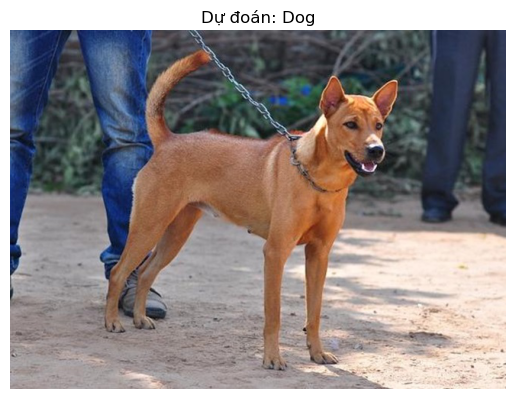

In [79]:
test_image_path = '/Users/minhkha/Downloads/image9-1631785551-12-width650height470.jpg'  
img = cv2.imread(test_image_path)
label = classify_image(img, cls_model, cls_scacler)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Dự đoán: {label}")
plt.axis('off')
plt.show()

INFO:root:Xử lý ảnh: /Users/minhkha/Downloads/image9-1631785551-12-width650height470.jpg
INFO:root:Dự đoán nhãn: Dog


size: (470, 650, 3)


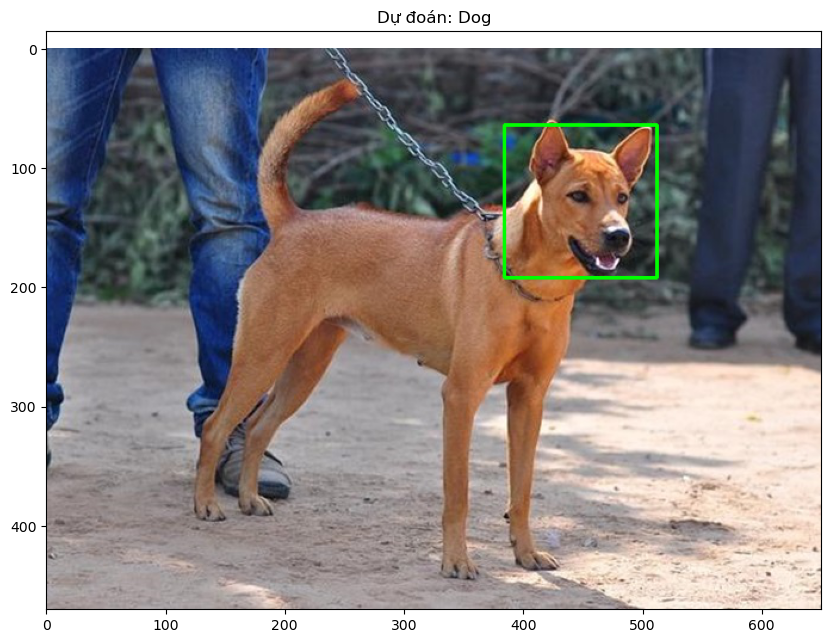

([384, 64, 512, 192], 0.6466878199692052, 'Dog')

In [80]:
# def test_image(image_path, step_size=16, score_threshold=0.5, scale=0.5, return_boxes=True):
test_image_path = '/Users/minhkha/Downloads/image9-1631785551-12-width650height470.jpg'  
img = cv2.imread(test_image_path)
print(f"size: {img.shape}")
test_image(test_image_path, return_boxes=False)

INFO:root:Xử lý ảnh: /Users/minhkha/Downloads/cho-bac-ha-dep-11.png


INFO:root:Dự đoán nhãn: Dog


size: (525, 700, 3)


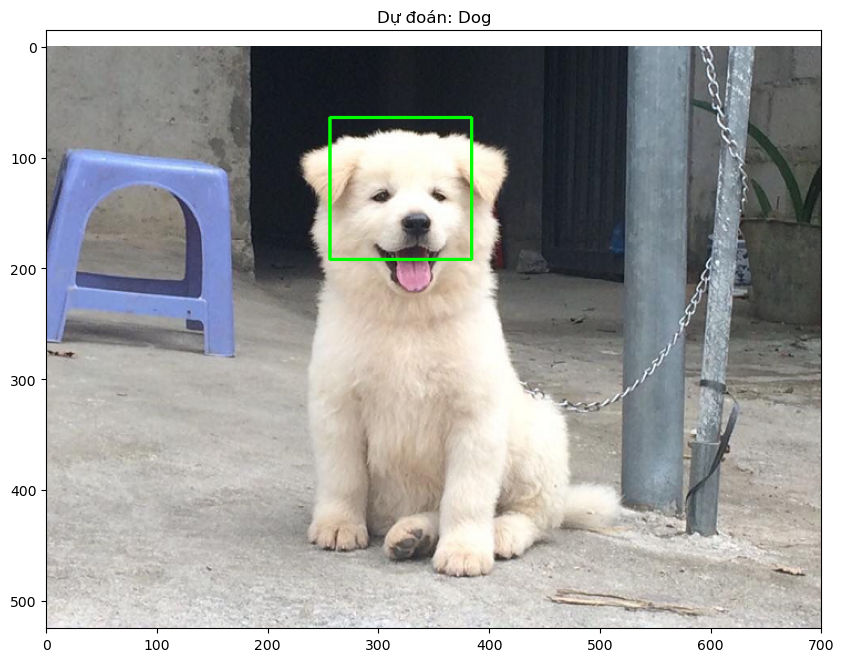

([256, 64, 384, 192], 0.6946796460019165, 'Dog')

In [89]:
# def test_image(image_path, step_size=16, score_threshold=0.5, scale=0.5, return_boxes=True):
test_image_path = '/Users/minhkha/Downloads/cho-bac-ha-dep-11.png'  
img = cv2.imread(test_image_path)
print(f"size: {img.shape}")
test_image(test_image_path, return_boxes=False)

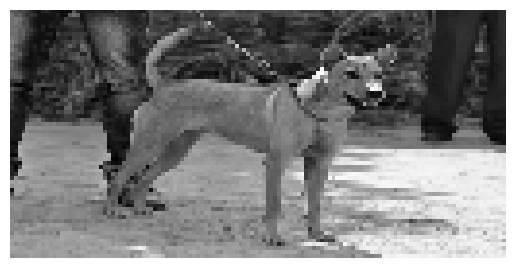

In [82]:
test_image_path = '/Users/minhkha/Downloads/image9-1631785551-12-width650height470.jpg'

# Đọc ảnh trực tiếp dưới dạng ảnh xám
img_gray = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

# Resize ảnh
img_gray = cv2.resize(img_gray, dsize=(128, 64))

# Hiển thị ảnh
plt.imshow(img_gray, cmap='gray')  # Sử dụng cmap='gray' để hiển thị ảnh xám
plt.axis('off')
plt.show()

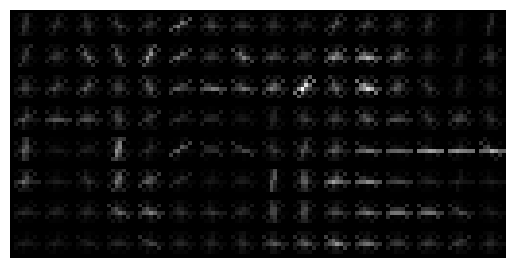

features: [0.2573031  0.25200567 0.10500062 ... 0.04915628 0.13527801 0.19148967]


In [83]:
features, hog_image = hog(img_gray,
                          orientations=9,
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2),
                          block_norm='L2-Hys',
                          visualize=True)

# Hiển thị ảnh gốc và ảnh HOG
#plt.figure(figsize=(5, 10))
plt.imshow(hog_image, cmap='gray')
plt.axis('off')
plt.show()

print(f"features: {features}")

INFO:root:Xử lý ảnh: /Users/minhkha/Desktop/CS231/Đồ án/data/images/american_bulldog_108.jpg
INFO:root:Dự đoán nhãn: Dog


size: (500, 375, 3)


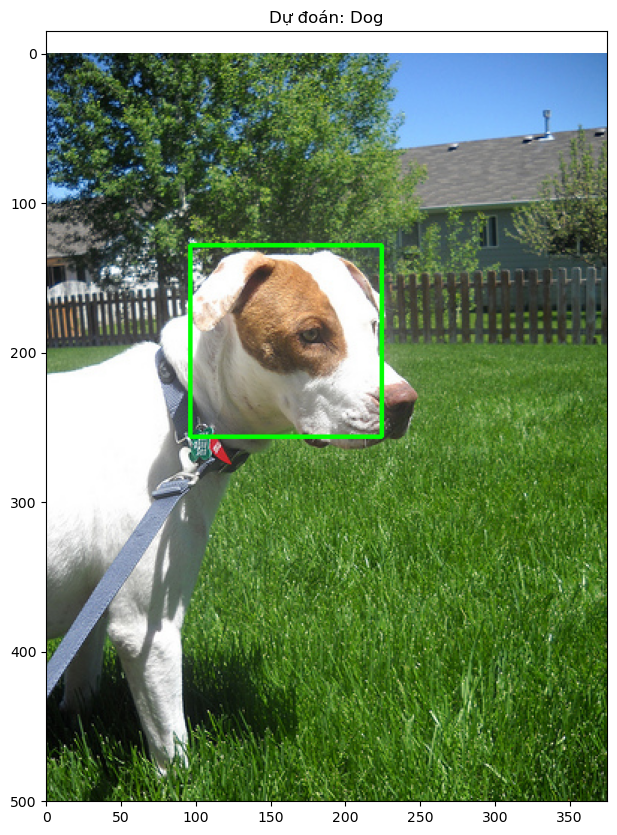

([96, 128, 224, 256], 1.497869170305632, 'Dog')

In [84]:
test_image_path = '/Users/minhkha/Desktop/CS231/Đồ án/data/images/american_bulldog_108.jpg'
img = cv2.imread(test_image_path)
print(f"size: {img.shape}")
test_image(test_image_path, return_boxes=False)

In [85]:
# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'gamma': ['scale', 'auto', 0.1, 1],
#     'kernel': ['rbf', 'linear']
# }
# from sklearn.model_selection import GridSearchCV
# model = GridSearchCV(
#         SVC(probability=True), 
#         param_grid, 
#         scoring='accuracy',
#         cv=5, 
#         n_jobs=-1
#     )

# model.fit(X_train_scaled, y_train)
# print(f"Best params: {model.best_params_}")
# print(f"Best score: {model.best_score_:.4f}")

In [86]:
# # Huấn luyện SVM
# cls_model = SVC(kernel='rbf', C=10, gamma='scale' ,random_state=42)
# cls_model.fit(X_train_scaled, y_train)